Based on the initial results of v1, in this version I will dig into the data features.
Geomagnetic location, time stamp etc, to see if these helps.

In [1]:
import calendar
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# numerical analysis
import numpy as np
import scipy.stats as stats
from collections import Counter

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, auc, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve)

# hyper-params optimisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model explainability
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay as pdp

# counterfactual
from itertools import product

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')


c:\Users\wyr95\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All done...


In [2]:
# # define some useful functions
def plot_ctr_by_numerical_columns(
        df,                     # pandas DataFrame containing your data
        cols,                   # list of numerical column names to analyze
        *,                      # force keyword-only arguments after this
        n_rows: int = 2,        # number of rows in subplot grid
        n_cols: int = 4,        # number of columns in subplot grid
        n_bins: int = 8,         # number of equal-width bins for bar plots
        rolling_window: int = 15, # smoothing window for CTR curves
        figsize: tuple = (30, 8), # size of the overall figure
        num_colors = None,        # color palette for lines
        bins_map: dict | None = None,   # custom binning rules per column
        smooth_map: dict | None = None  # custom smoothing rules per column
    ):
    """
    CTR = Click Through Rate = total clicks / total ads
    """
    
    if num_colors is None:
        num_colors = sns.color_palette('tab10', len(n_cols))
    
    bins_map = bins_map or {}
    smooth_map = smooth_map or {}
    
    plt.figure(figsize=figsize)
    
    # smooth line plots
    for i, col in enumerate(cols, start = 1):
        ax = plt.subplot(n_rows, n_cols, i)
        df_temp = df.copy()
        df_temp[col] = df_temp[col].round(1)

        grouped = (
            df_temp.groupby(col).agg(total_clicks = ('Clicked_on_Ad', 'sum'),
                                     total_ads = ('Clicked_on_Ad', 'count')).sort_index())
        
        grouped['ctr'] = grouped['total_clicks'] / grouped['total_ads']
        win = smooth_map.get(col, rolling_window) # get custom smoothing if provided
        grouped['ctr_smooth'] = (
            grouped['ctr'].rolling(window = win, center = True, min_periods = 1).mean())
        
        sns.lineplot(
            ax = ax, 
            x = grouped.index,
            y = grouped['ctr_smooth'],
            markers='o', 
            color = num_colors[i - 1])
        
        plt.title (f'CTR by {col} (smoothed, win = {win})', fontsize = 20)
        plt.xlabel(col.title(), fontsize = 15)
        plt.ylabel('CTR', fontsize = 15)

    
    # bar plots
    for i, col in enumerate(cols, start= len(cols) + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        bins = bins_map.get(col, n_bins)
        bin_labels = [f'B{i}' for i in range(1, bins + 1)]
        df[f'{col}_bin'] = pd.cut(df[col], bins = bins, labels = bin_labels)
        
        grouped_bin = (
            df.groupby(f'{col}_bin').agg(total_clicks = ('Clicked_on_Ad', 'sum'),
                                         total_ads = ('Clicked_on_Ad', 'count')).sort_index()
        )

        grouped_bin['ctr'] = grouped_bin['total_clicks'] / grouped_bin['total_ads']

        sns.barplot(
            ax = ax, 
            x = grouped_bin.index,
            y = grouped_bin['ctr'],
            color=num_colors[i - len(cols) - 1]
        )

        plt.title(f'CTR by {col} (equal-width bins={bins})', fontsize = 20)
        plt.xlabel(f'{col.title()} Bins', fontsize = 15)
        plt.ylabel('CTR', fontsize = 15)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
        

    
    


In [3]:
def part_of_day(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 17:
        return 1
    elif 17 <= hour < 21:
        return 2
    else:
        return 3

In [4]:
def evaluate_classification_models(X_train, X_test, y_train, y_test, random_state = 32):
    models = {
        'Naive Bayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'Extra Trees': ExtraTreesClassifier(random_state=random_state),
        'SVM(RBF)': SVC(probability=True, random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'CatBoost': CatBoostClassifier(verbose=0, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'LightBGM': LGBMClassifier(random_state=random_state),
        'HistGradientBoosting': HistGradientBoostingClassifier(random_state=random_state),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state=random_state)
    }

    results = []
    for name, model in model.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True).T


In [5]:
def decode_value(row, label_encoders, key_column, value_column):
    """  Decodes an encoded value in `value_column` based on matching the `key_column` value
    to a key in label_encoders dict."""
    key_val = row[key_column]
    encoded_val = row[value_column]

    for key in label_encoders:
        if key in str(key_val):
            return label_encoders[key].inverse_transform([encoded_val])[0]
    return encoded_val

In [6]:
def generate_counterfactuals(sample_row, model, adjustable_features, possible_values_dict):
    sample = sample_row.copy()
    original_prob = model.predict_proba(sample.values.reshape(1, -1))[:,1][0]

    best_prob = original_prob
    best_changes = sample.copy()

    for features in adjustable_features:
        for val in possible_values_dict[features]:
            modified = sample.copy()
            modified[features] = val
            prob = model.predict_proba(modified.values.reshape(1, -1))[:,1][0]
            if prob > best_prob:
                best_prob = prob
                best_changes = modified.copy()
    
    data = []
    for col in sample.index:
        orig_val = sample[col]
        changed_val = best_changes if best_changes[col] != orig_val else '-'
        data.append({
            'feature_name': col,
            'feature_value': orig_val,
            'adjusted_value': changed_val
        })
    
    long_df = pd.DataFrame(data)
    return long_df, original_prob, best_prob




In [7]:
import os
# base_path = os.path.dirname(__file__)  # folder of py file
base_path = os.getcwd() # folder of jupyter notebook
csv_path = os.path.join(base_path, "Data", "ad_10000records.csv")

df = pd.read_csv(csv_path)
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))
# df.describe().T

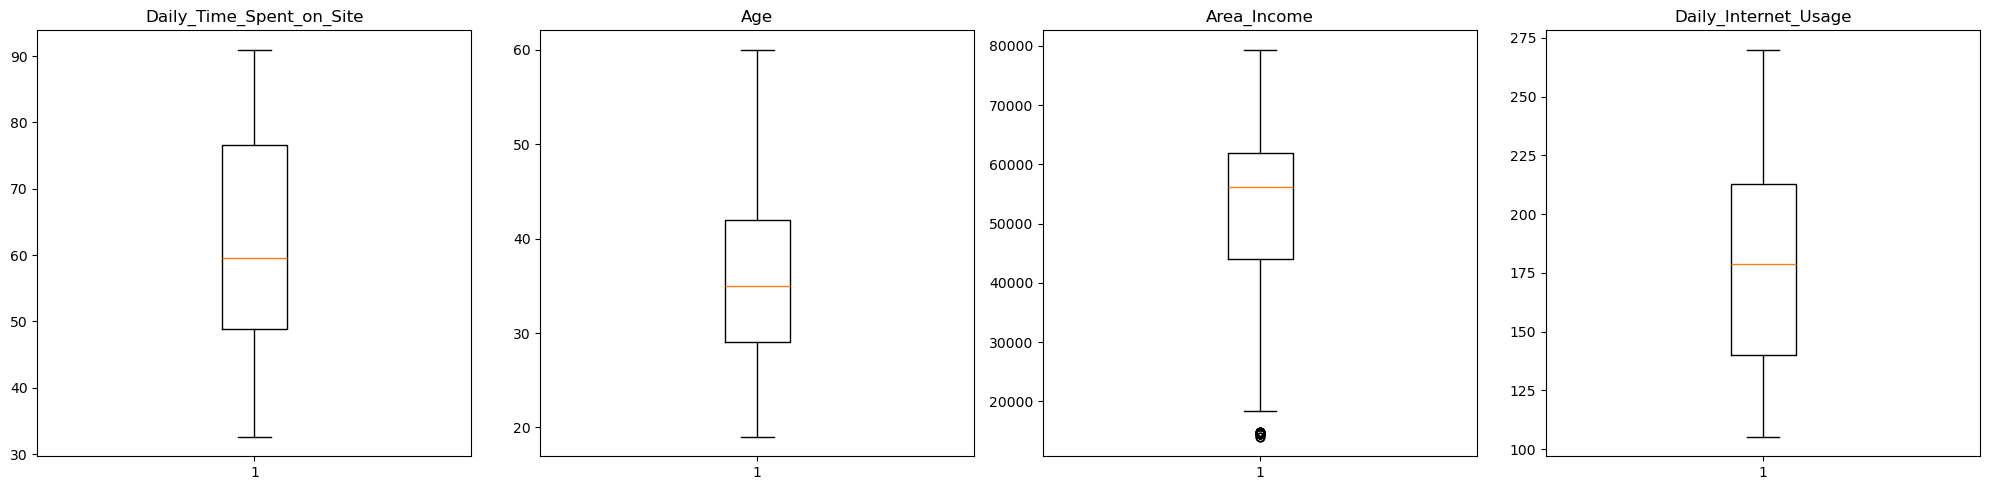

In [8]:
numerical_cols = df.select_dtypes(include = 'number').columns[:-1]

fig, axes = plt.subplots(1, len(numerical_cols), figsize = (20, 5))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [9]:
# extract time-connected features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday 
df['month'] = df['Timestamp'].dt.month

label_encoders = {}
for col in df.select_dtypes(include = 'object'):
    df[col] = df[col].str.title().str.strip()
    le = LabelEncoder()
    df[col + '_label'] = le.fit_transform(df[col])
    label_encoders[col] = le
    

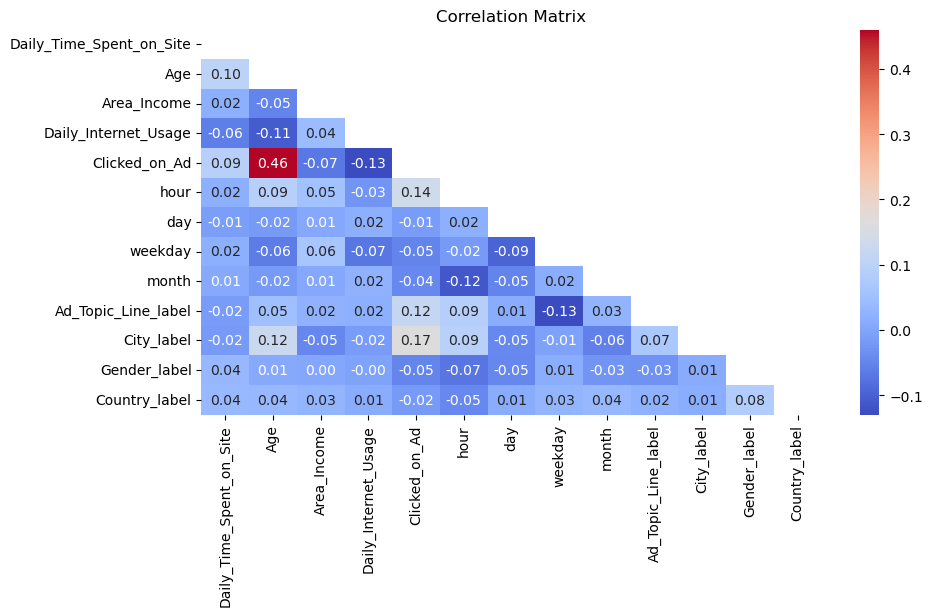

In [10]:
correlation_matrix = df[df.select_dtypes(include = 'number').columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (10, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', mask = mask)
plt.title('Correlation Matrix') 
plt.show()

Age is the only one labeled with red. If in the test part the model seems overfitted, we could considering about deleting "Age".

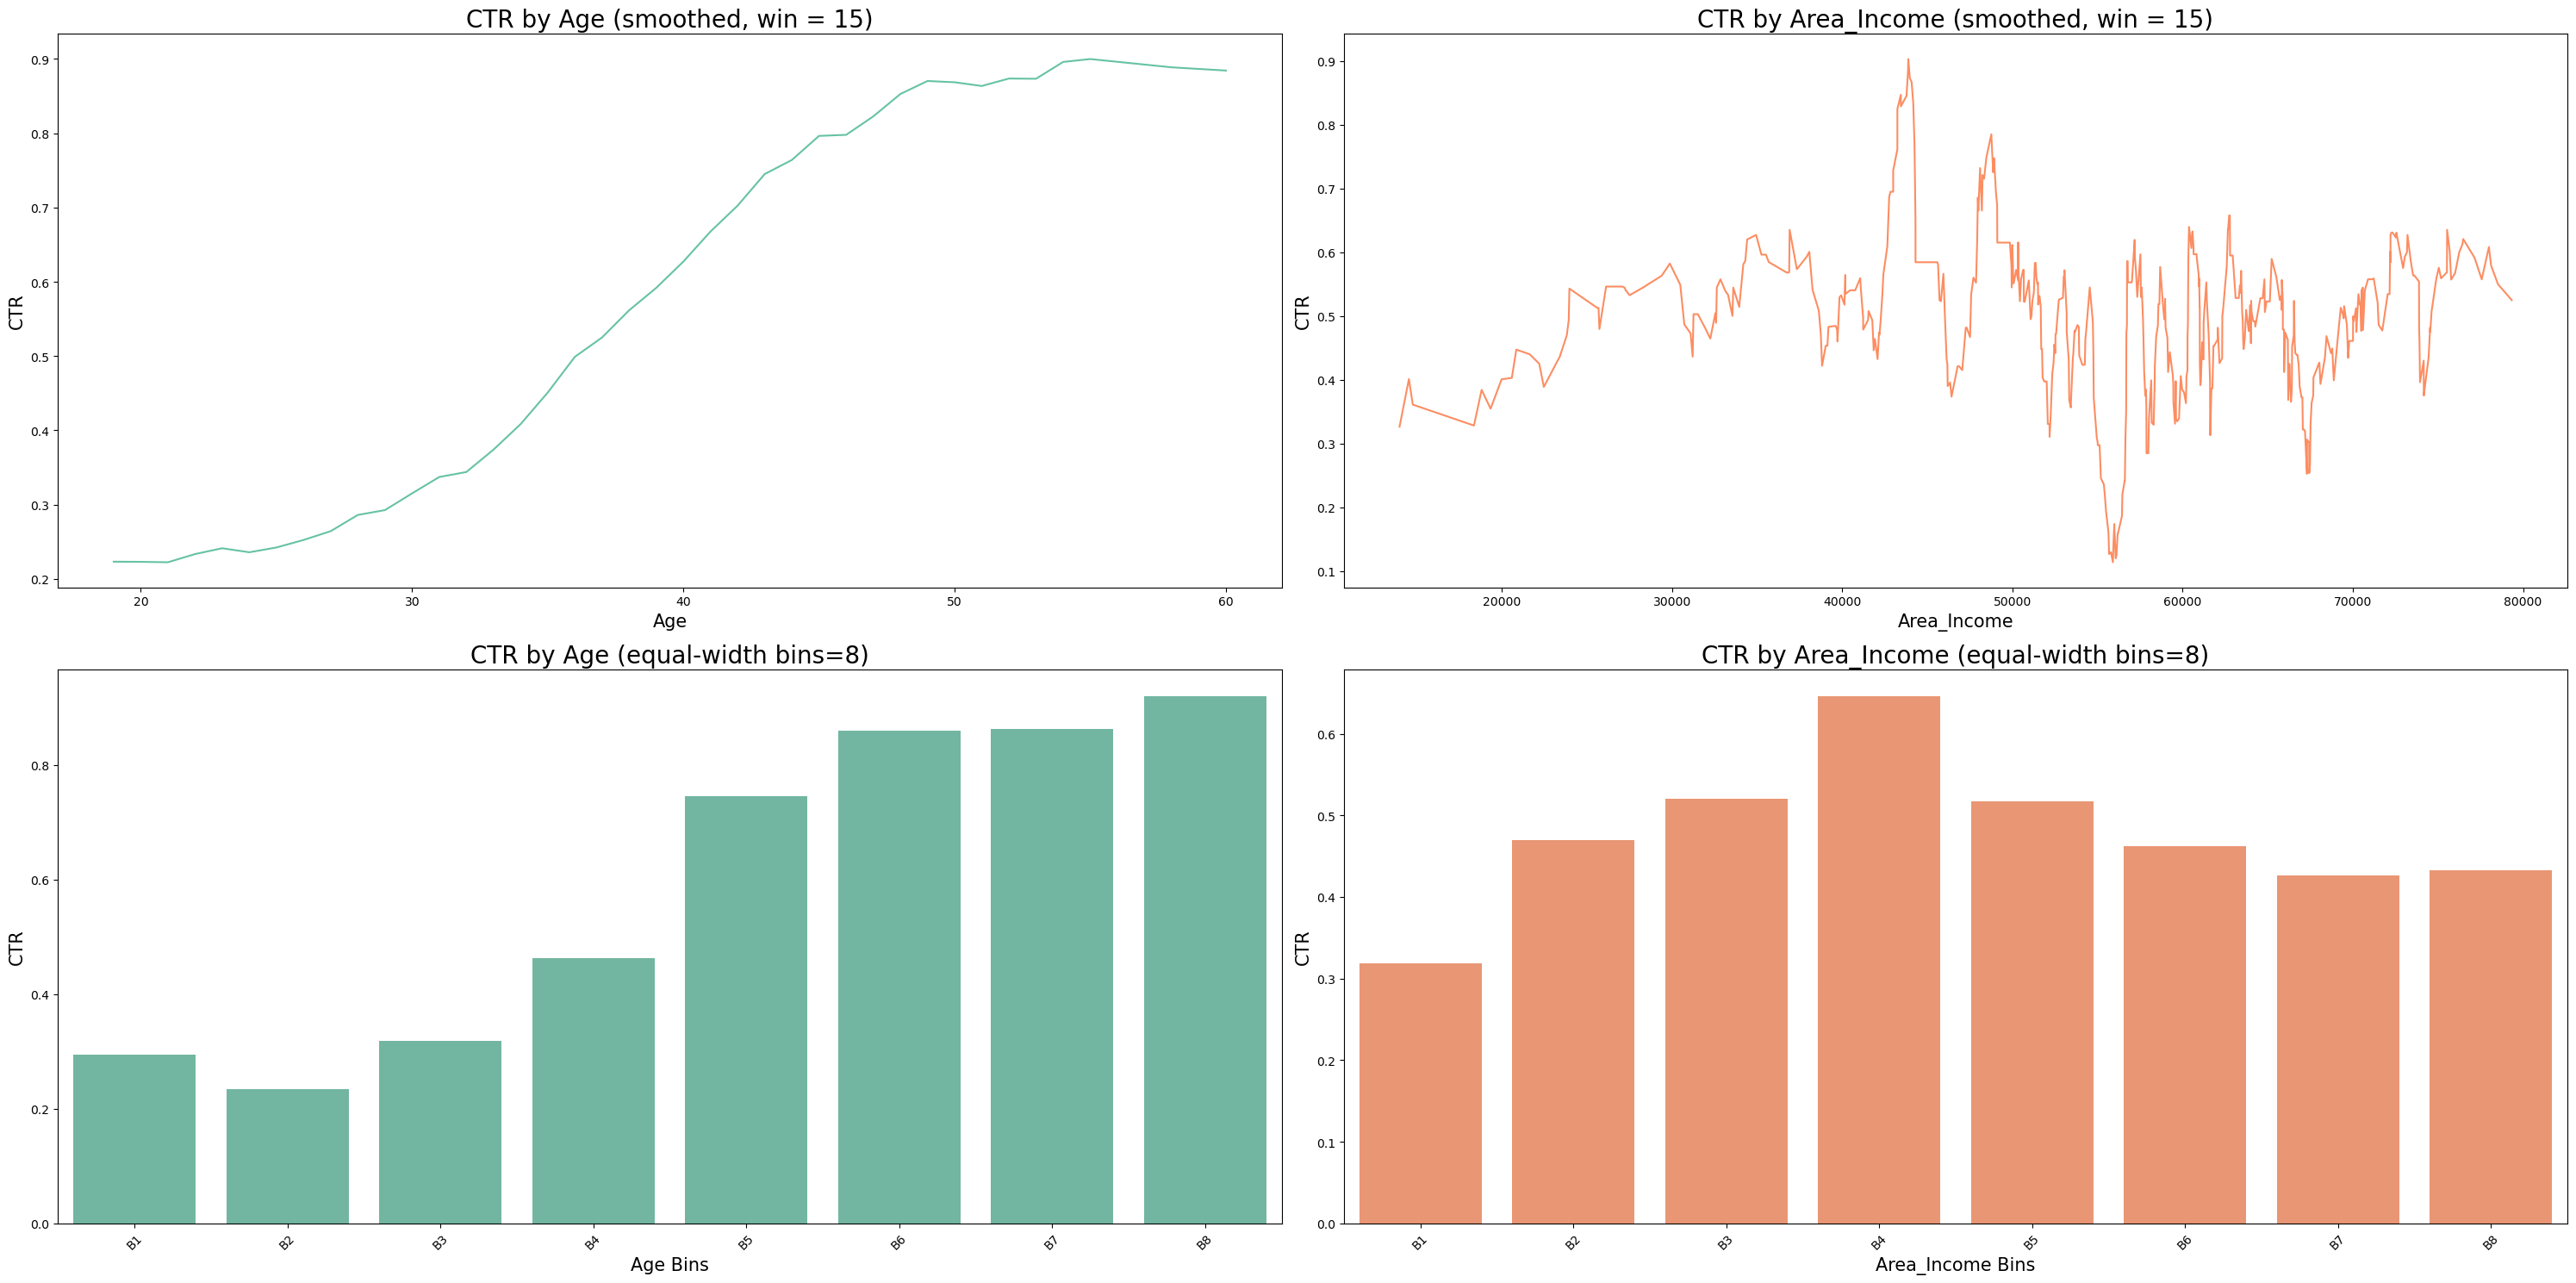

In [11]:
# analysis age and income
cols=['Age', 'Area_Income']
plot_ctr_by_numerical_columns(
    df=df,
    cols=cols,
    n_rows = len(cols),
    n_cols = len(cols),
    n_bins = 8,
    figsize = (30, 15),
    rolling_window=15,
    num_colors=sns.color_palette('Set2', 8) 
)

Analysis:
CTR increases along with age.
The connection with area income is non-linear. We can also see the peaks of CTR is at middile income levels (40k), higher or lower incomes corresponds to lower CTR.

For deeper analysis, maybe we can also check the relationship between age and income.


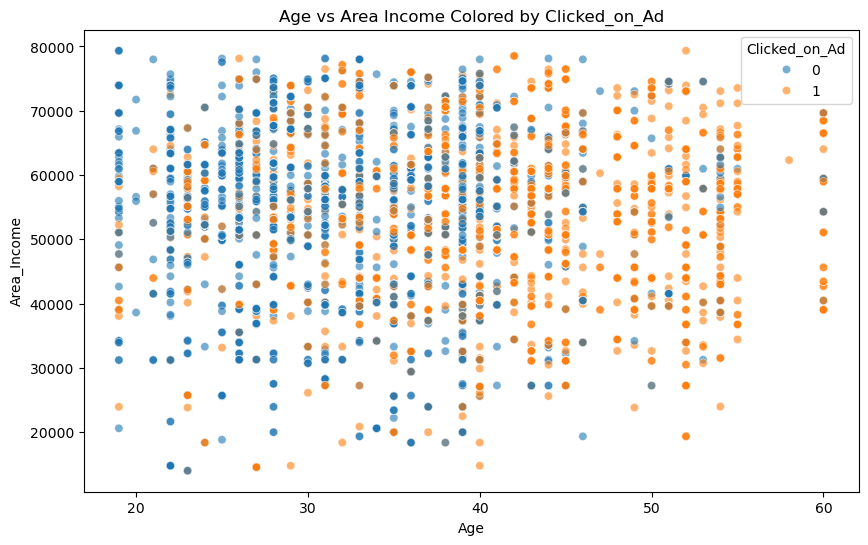

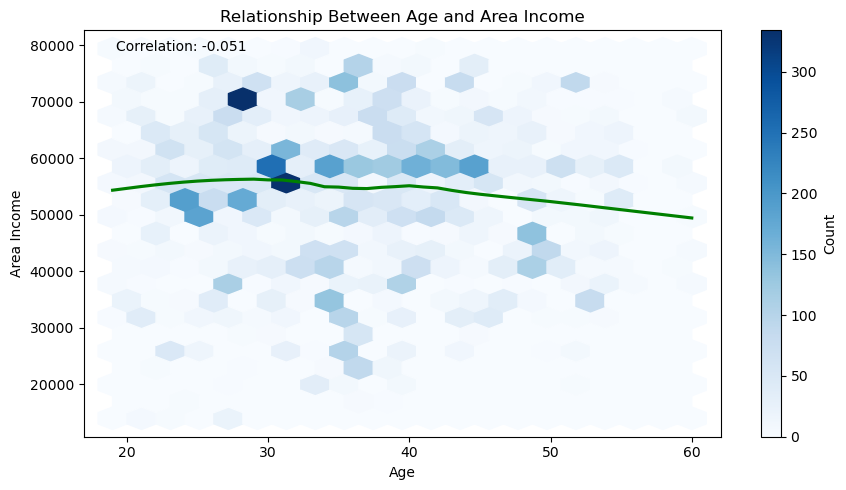

In [12]:
# analysis the age and the income
import statsmodels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='Area_Income', hue='Clicked_on_Ad', alpha=0.6)
plt.title('Age vs Area Income Colored by Clicked_on_Ad')    
plt.show()

##
plt.figure(figsize = (9, 5))

plt.hexbin(df['Age'], df['Area_Income'], gridsize = 20, cmap = 'Blues')
plt.colorbar(label = 'Count')

sns.regplot(data = df, x = 'Age', y = 'Area_Income', scatter = False, 
            lowess = True, line_kws = {'color': 'green'})

plt.title('Relationship Between Age and Area Income')
plt.xlabel('Age')
plt.ylabel('Area Income')

correlation = df['Age'].corr(df['Area_Income'])
plt.annotate(f'Correlation: {correlation:.3f}', 
             xy = (0.05, 0.95), xycoords = 'axes fraction')

plt.tight_layout()
plt.show()


So age and income do not have a linear relationship.


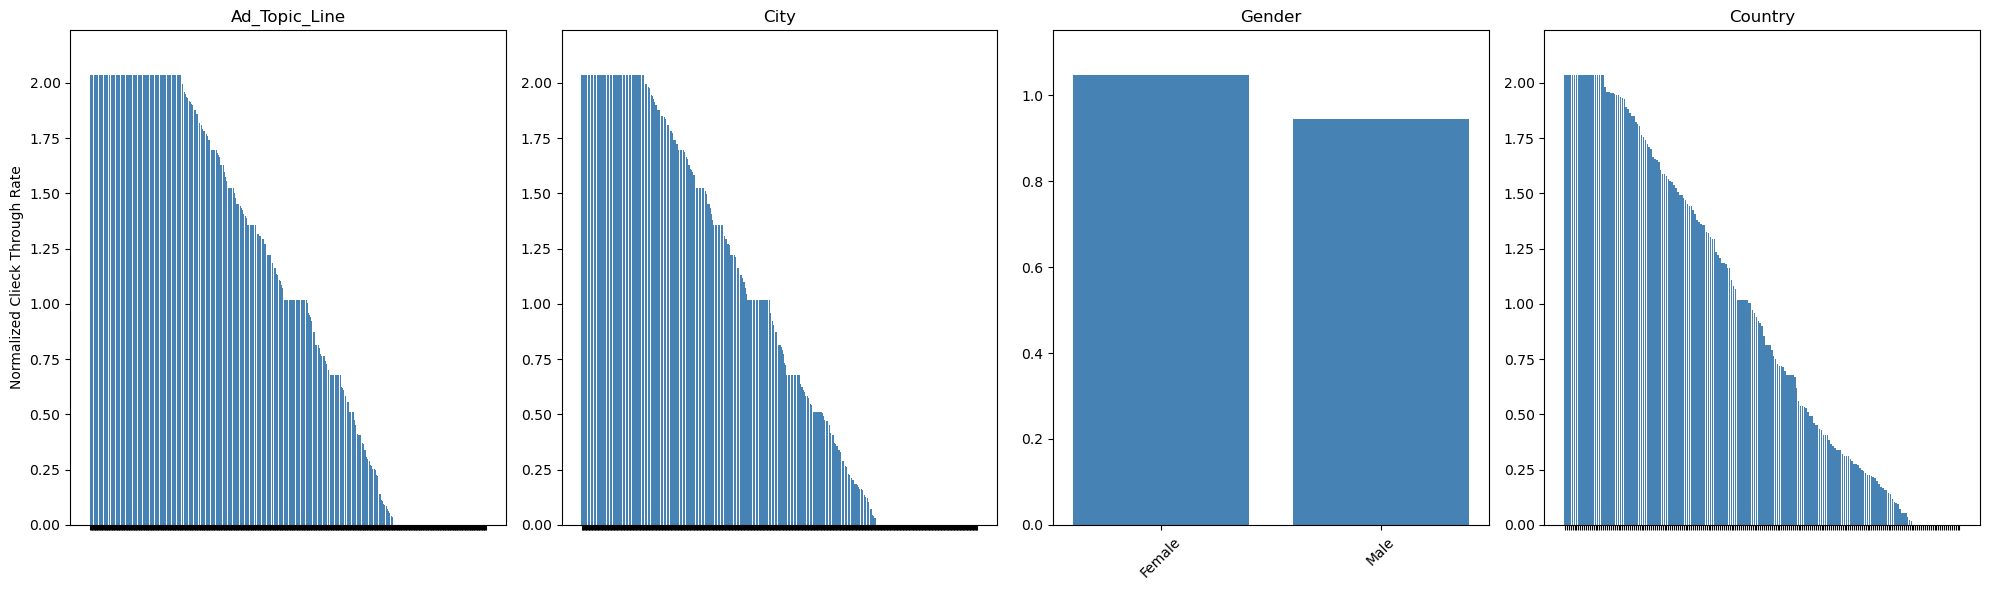

In [20]:
# analysis CTR with each features
categorical_cols = df.select_dtypes(include = 'object').columns.tolist()

total_clicks = df['Clicked_on_Ad'].sum()
total_impressions = len(df)
overall_ctr = total_clicks / total_impressions

plt.figure(figsize = (20, 6))
for i, col in enumerate(categorical_cols, start=1):
    clicks_by_col = df.groupby(col)['Clicked_on_Ad'].sum()
    ads_send_by_col = df.groupby(col)['Clicked_on_Ad'].count()

    ctr_by_col = clicks_by_col / ads_send_by_col
    normalized_ctr_by_col = ctr_by_col / overall_ctr
    normalized_ctr_by_col = normalized_ctr_by_col.sort_values(ascending = False)

    plt.subplot(1, len(categorical_cols), i)
    bars = plt.bar(range(len(normalized_ctr_by_col)), normalized_ctr_by_col.values, color = "steelblue") 
    
    plt.title(f'{col}', fontsize = 12)
    plt.ylim(0, normalized_ctr_by_col.max() * 1.1)
    
    if col == "Gender":
        plt.xticks(range(len(normalized_ctr_by_col)), normalized_ctr_by_col.index, rotation = 45)
    else:
        plt.xticks(range(len(normalized_ctr_by_col)), [''] * len(normalized_ctr_by_col))

    if i == 1:
        plt.ylabel('Normalized Clieck Through Rate')

plt.tight_layout()
plt.show()



Ad_topic_line, city and country are aassociated with CTR. 
In Gender, females account for a majority for CTR.

Then we would like to check the top cities and ad topic for further details analysis.

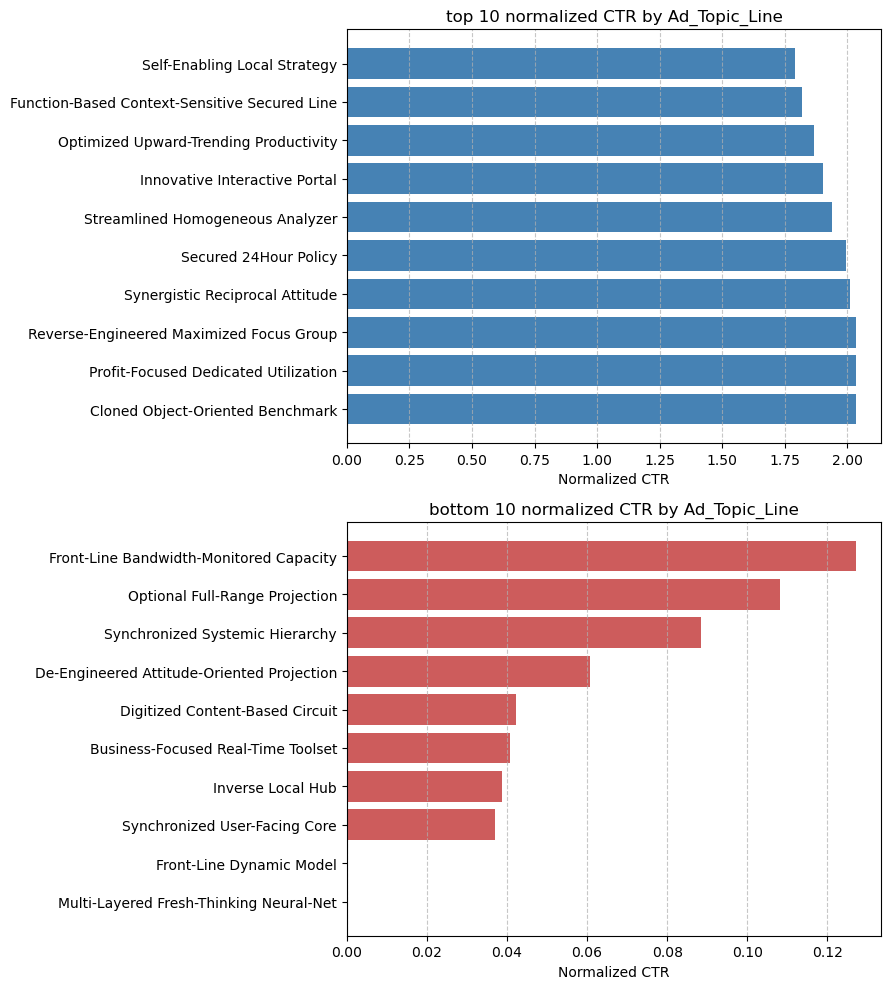

Top cities from top countries:


,City,Country


Bottom cities from bottom countries:


,City,Country


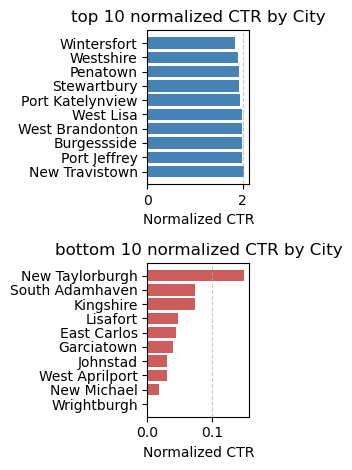

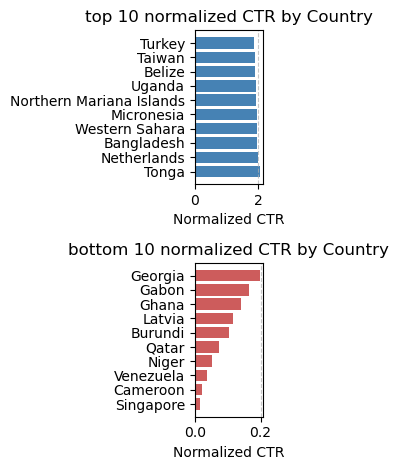

In [26]:
min_volumn = 50
categorical_cols = ['Ad_Topic_Line', 'City', 'Country']

# overall CTR for the entire dataset
plt.figure(figsize=(20,10))
for i, col in enumerate(categorical_cols): # start 1?
    # group by category
    grouped = df.groupby(col)['Clicked_on_Ad']
    clicks = grouped.sum()
    impression = grouped.count()
    ctr = clicks / impression

    normalized_ctr = ctr / overall_ctr

    valid = impression[impression >= min_volumn].index
    normalized_ctr = normalized_ctr.loc[valid]
    impression = impression.loc[valid] # here keeps the ctr and impression when the counters are lager than the min_volumn
    # it is kind of filrers that select data with enough volume

    # top 10 and bottom 10 ranking
    top_10 = normalized_ctr.sort_values(ascending=False).head(10)
    bottom_10 = normalized_ctr.sort_values(ascending=True).head(10)

    plt.subplot(2, len(categorical_cols), i+1)
    plt.barh(top_10.index, top_10.values, color='steelblue')
    plt.title(f'top 10 normalized CTR by {col}')
    plt.xlabel('Normalized CTR')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.subplot(2, len(categorical_cols), i+1+len(categorical_cols))
    plt.barh(bottom_10.index, bottom_10.values, color='indianred')
    plt.title(f'bottom 10 normalized CTR by {col}')
    plt.xlabel('Normalized CTR')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # find the cities corresponding to the country
    if col == 'City':
        top_cities = top_10.index
        botttom_cities = bottom_10.index

        # find the countries corresponding to the cities
        top_city_country = df[df['City'].isin(top_cities)][['City', 'Country']].drop_duplicates()
        bottom_city_country = df[df['City'].isin(botttom_cities)][['City', 'Country']].drop_duplicates()

        top_country = normalized_ctr.sort_values(ascending=False).head(10).index
        bottom_country = normalized_ctr.sort_values(ascending=True).head(10).index

        top_cities_from_top_countries = top_city_country[top_city_country['Country'].isin(top_country)]
        bottom_cities_from_bottom_countries = bottom_city_country[bottom_city_country['Country'].isin(bottom_country)]

        print("Top cities from top countries:")
        display(top_cities_from_top_countries)
        print("Bottom cities from bottom countries:")
        display(bottom_cities_from_bottom_countries)

    plt.tight_layout()
    plt.show()



There are no top cities from the top country, either no bottom cities from the bottom country.
The most possible reason is that the database is a toy example ^^

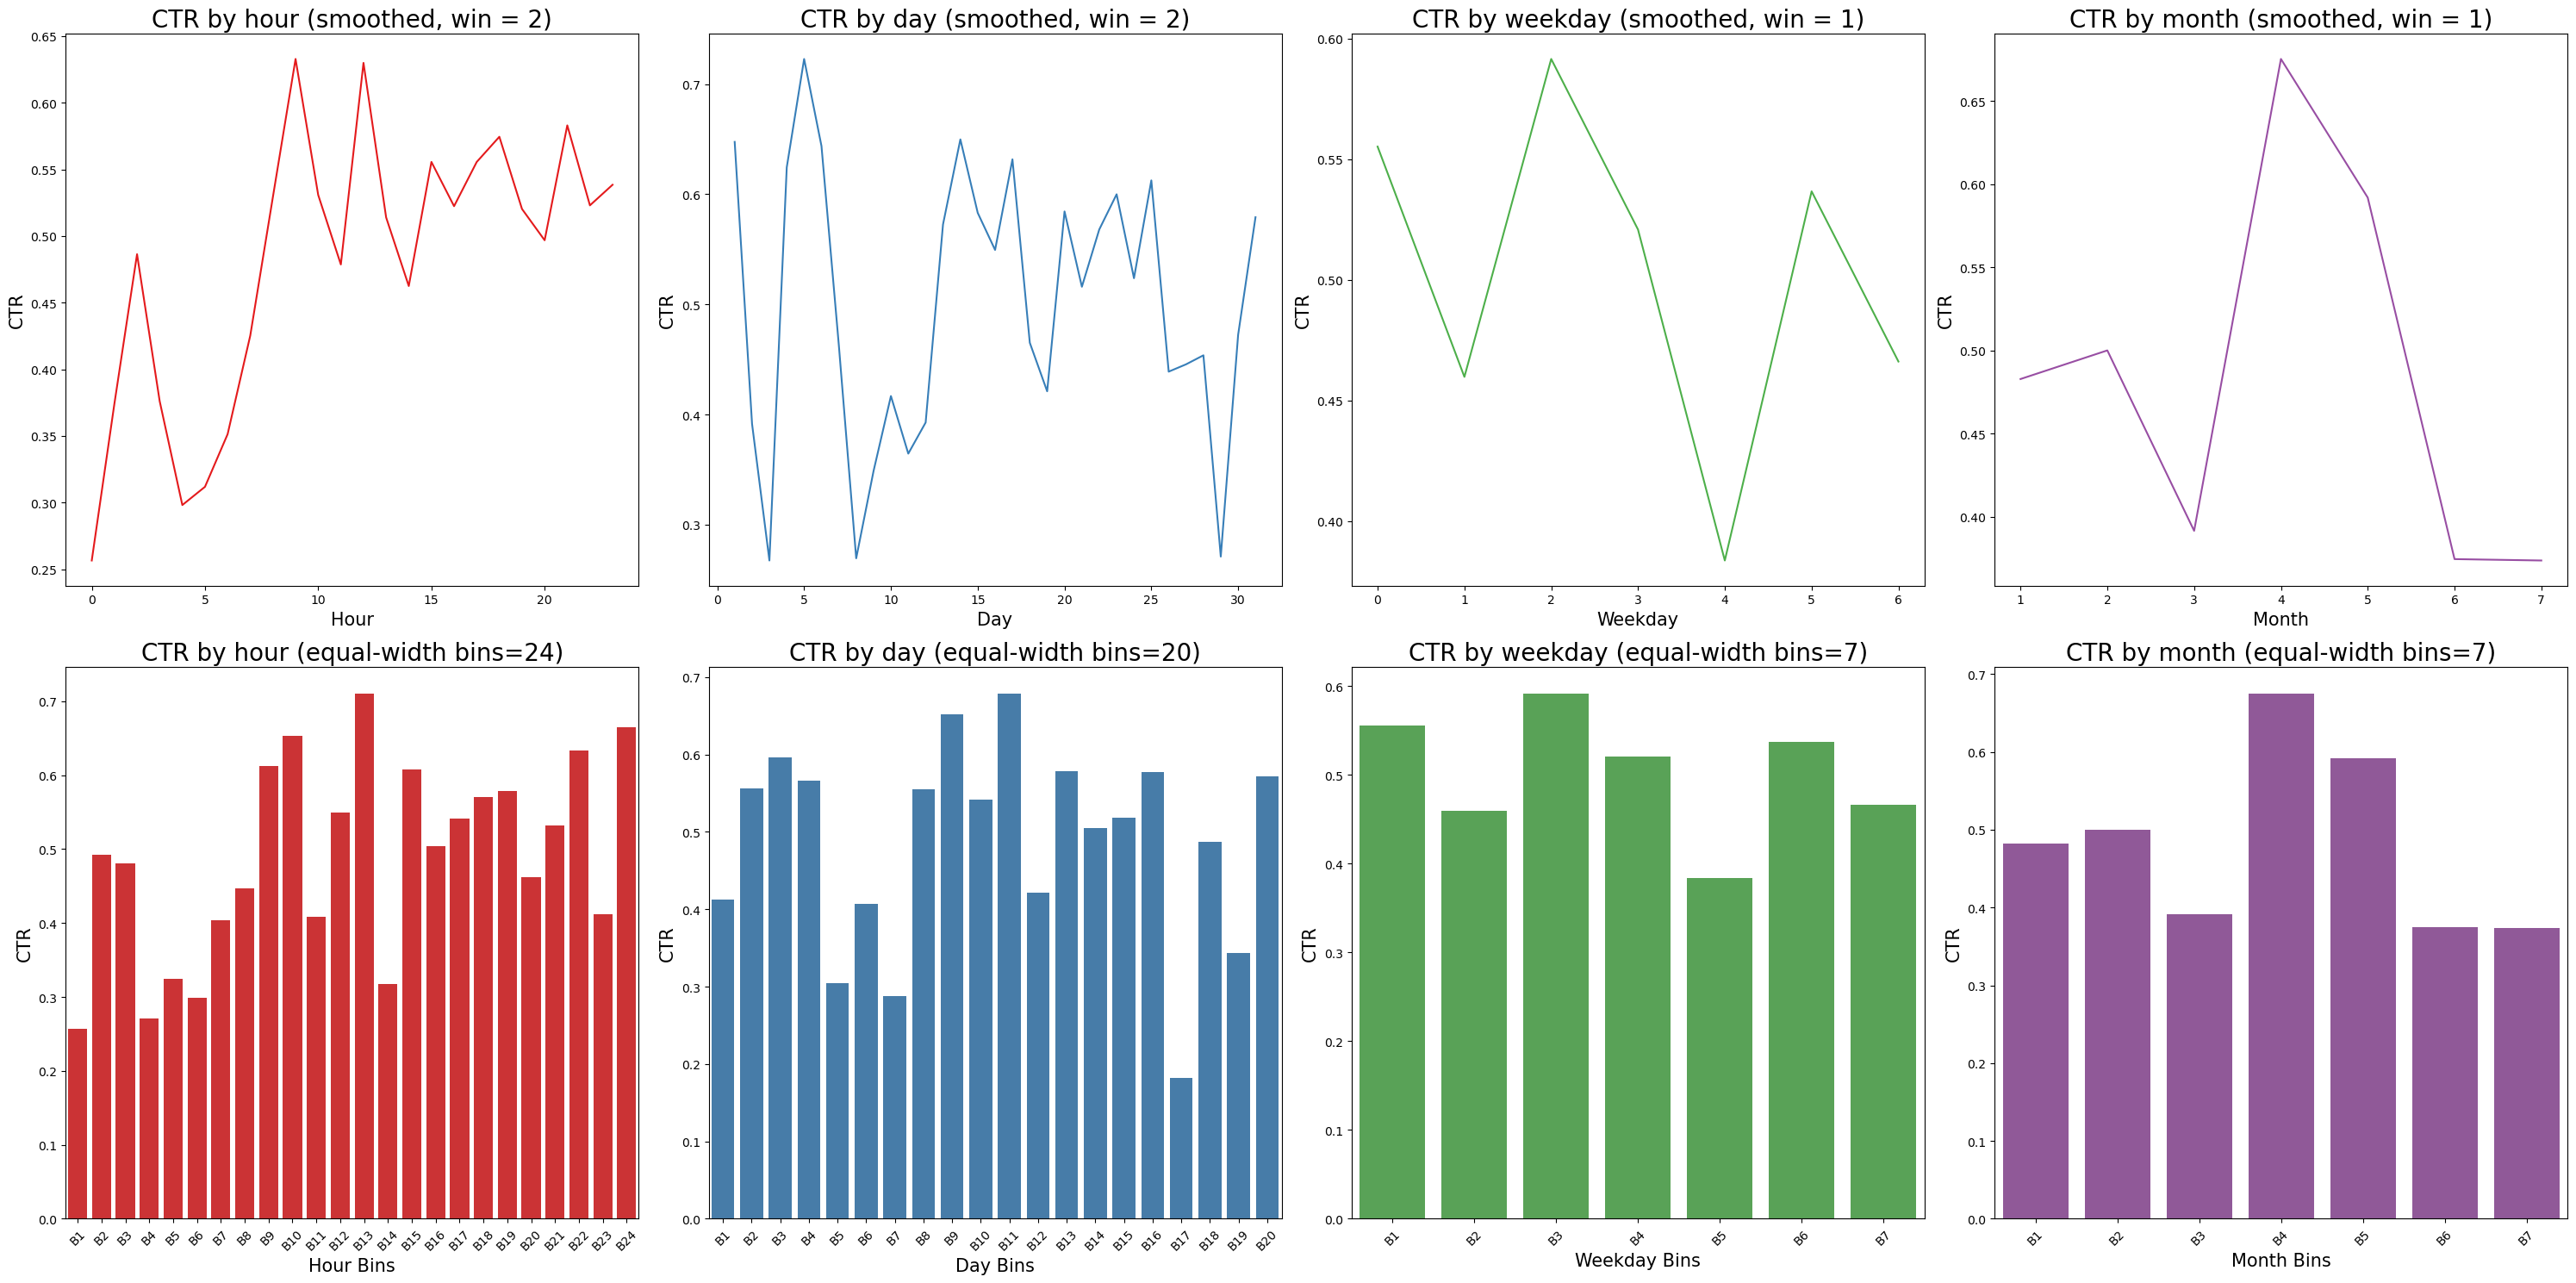

In [36]:
# time based analyssi
plot_ctr_by_numerical_columns(
    df = df,
    cols = ['hour', 'day', 'weekday', 'month'],
    n_rows= 2,
    n_cols= 4,
    n_bins= 7,
    bins_map = {'hour': 24,'day': 20, 'month': 7},
    smooth_map = {'hour': 2,'day': 2},
    figsize= (30, 15),
    rolling_window=1,
    num_colors=sns.color_palette('Set1', 8)
)

peaks occurs on hours of 13, 10. Everning is higher than morning. 
Begining of month is higher. Middle (11) is high.
Wensday is the highest, then Tuesday. Weekend is lower. Friday is the lowest.
April is the highest.


Observation

Ad performance varies significantly across time. Click-through rates (CTR) peak during specific hours (10AM, 12PM, and 8PM) and days (Wednesdays, as well as start and middle of the month), while ad delivery tends to concentrate late at night. Notably, April (B4) sees the highest monthly CTR, followed by a noticeable dip in June and July.

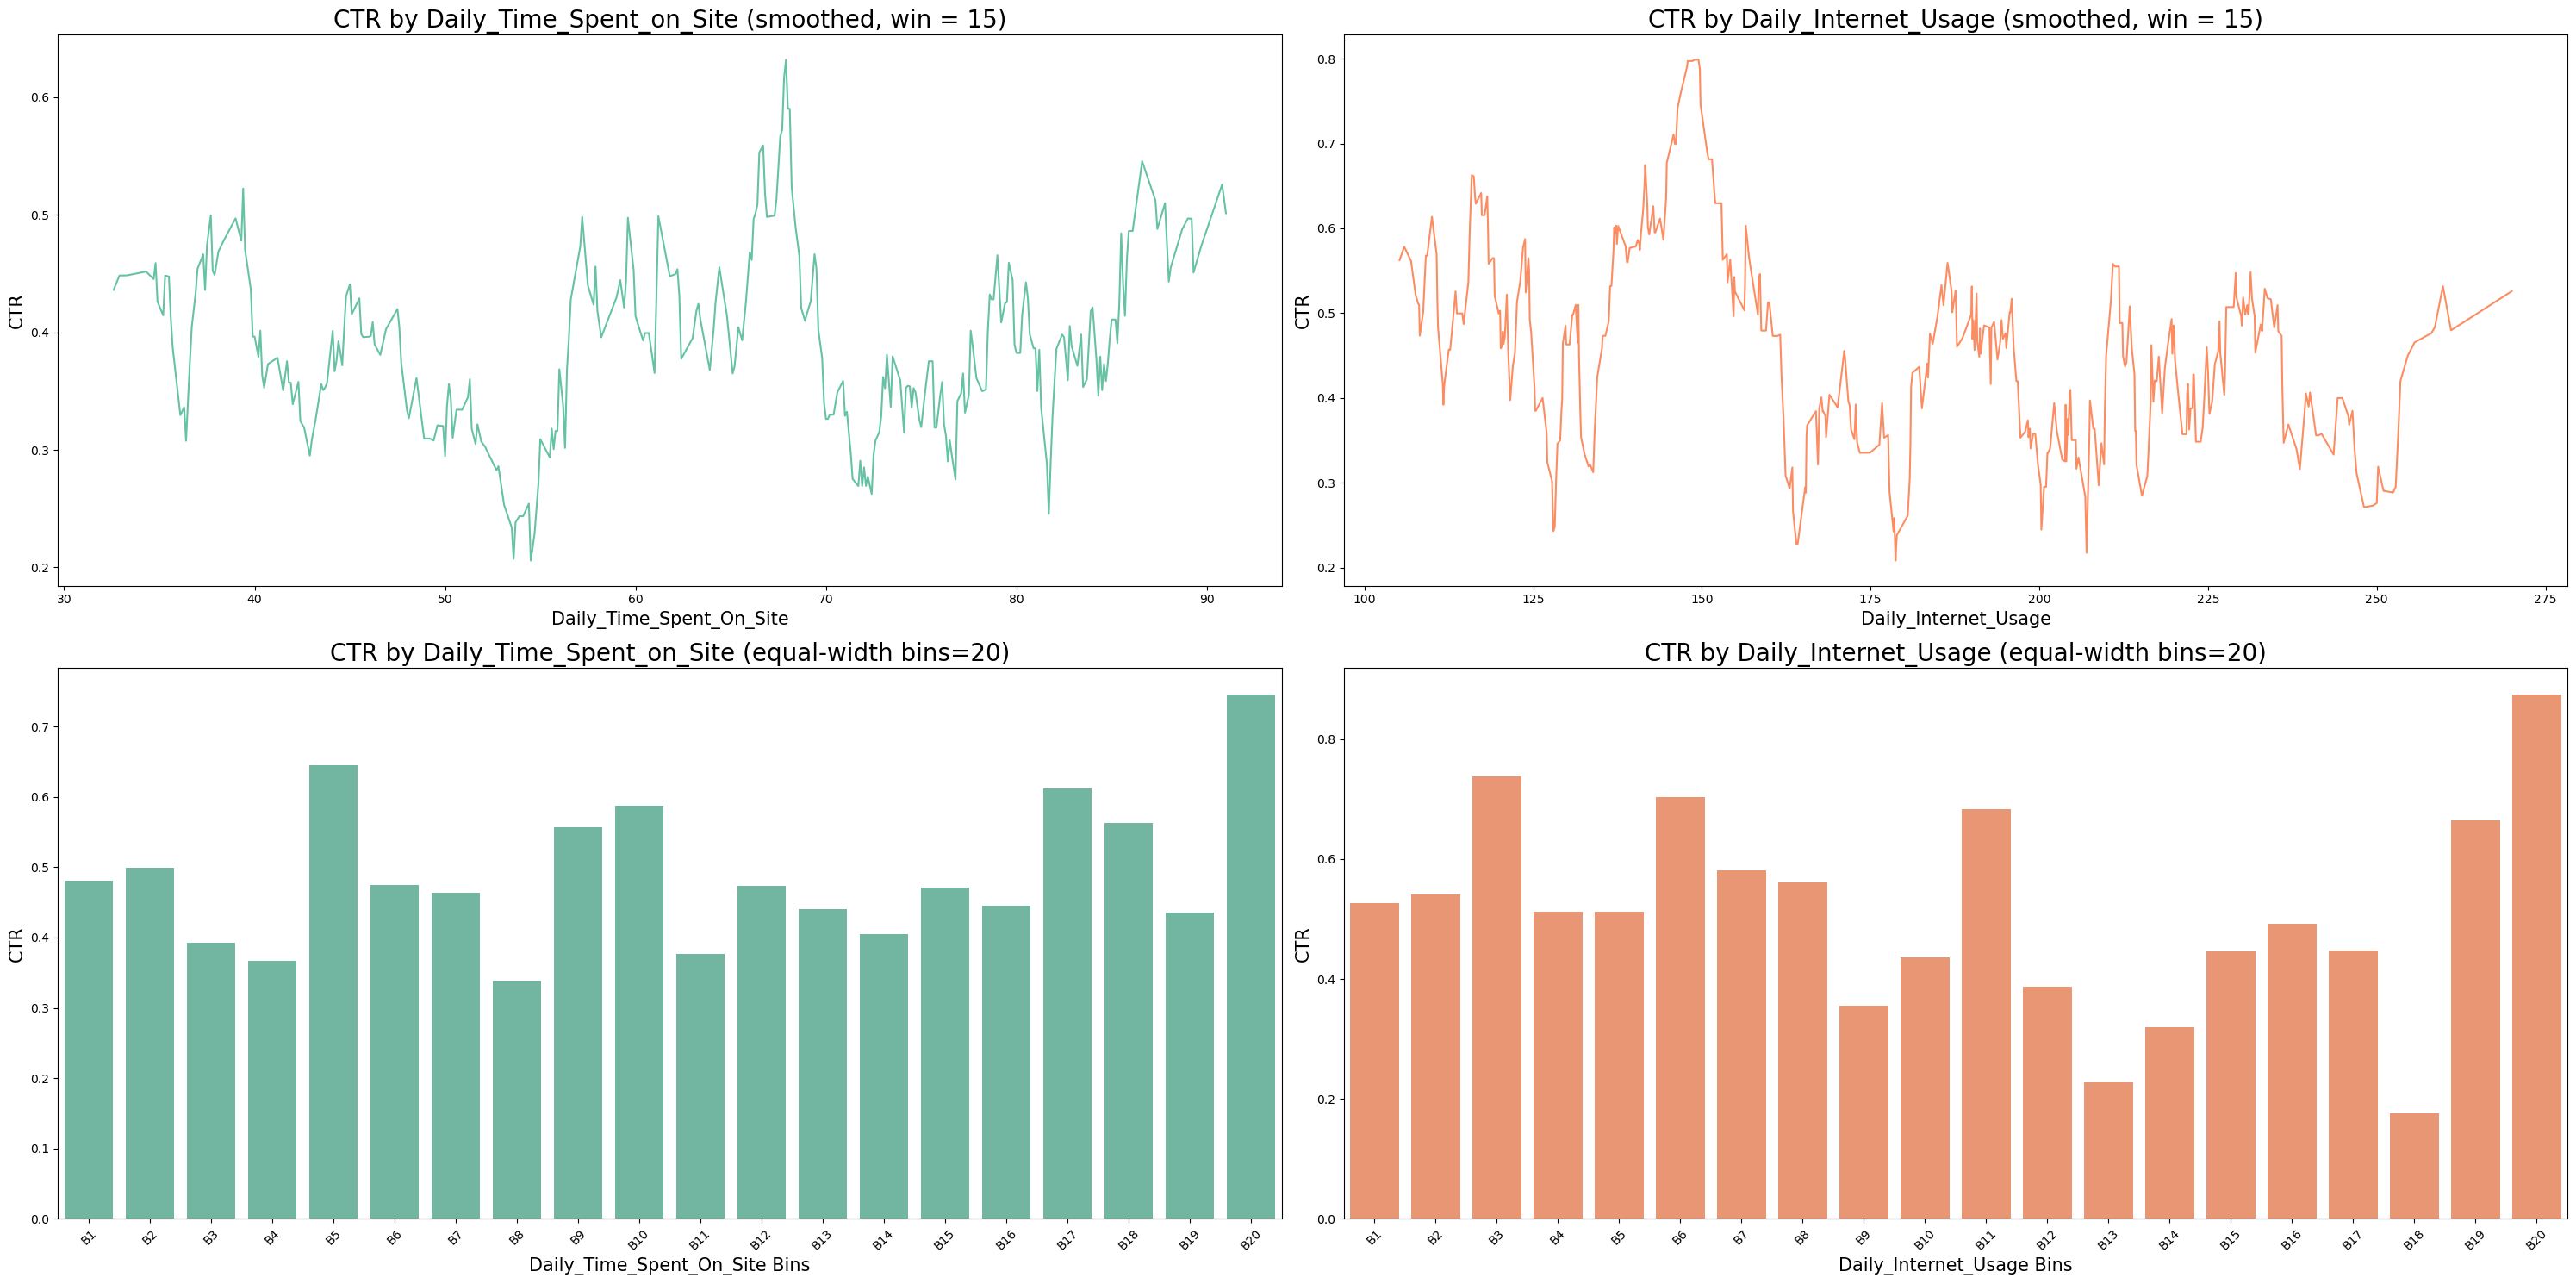

In [44]:
plot_ctr_by_numerical_columns(
    df = df,
    cols = ['Daily_Time_Spent_on_Site', 'Daily_Internet_Usage'],
    n_rows = 2,
    n_cols = 2,
    n_bins = 20,
    figsize = (30, 15),
    rolling_window = 15,
    num_colors = sns.color_palette("Set2", 8))


CTR is aroud peaks with "daily time spend on site" aroud 60 to 70.
"daily internet usage" is around 150. (what does this mean?)

CTR tends to increase with moderate user engagement, peaking with around 70 minutes on site and moderate daily internet usage but declines at extreme levels.

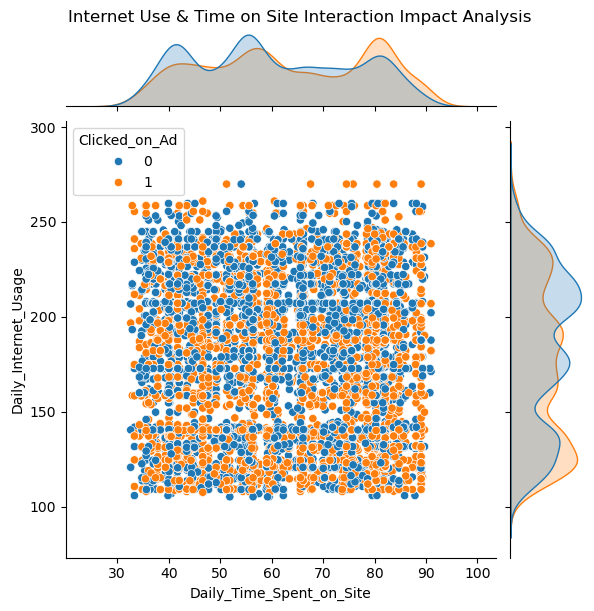

In [54]:
# Internet Use & Time on Site Interaction Impact Analysis
sns.jointplot(
    data=df,
    x='Daily_Time_Spent_on_Site',
    y='Daily_Internet_Usage',
    hue='Clicked_on_Ad',
    height=6
)
plt.suptitle('Internet Use & Time on Site Interaction Impact Analysis',y = 1.01)
plt.show()

In [ ]:
# Model training and evaluation
drop_cols = ['Clicked_on_Ad', 'Ad_Topic_Line', 'City', 'Country', 'Timestamp']
drop_cols.extend([col for col in df.columns if 'bin' in col])

X = df.drop(columns = drop_cols, axis=1)
Y = df['Clicked_on_Ad']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=32, stratify=Y)

print(f'Train Set Split:{y_train.value_counts()}')
print(f'Test Set Split:{y_test.value_counts()}')


